In [1]:
__author__ = "Rohit Lal"
__copyright__ = "Copyright (C) 2020 Rohit Lal"
__license__ = "MIT"
__version__ = "1.0"

In [1]:
%matplotlib inline
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np,os

## The classes imported below are used for dataloader, transformation and model

from DAE_dataset_helper import OrigamiDatasetGenerate,ValidationGenerate
from DAE_dataset_helper import ToTensor,Resize, Normalize
from DAE_dataset_helper import ToTensorValidate,NormalizeValidate,ResizeValidate
from DAE_model import AugmentedAutoencoder # contains various models to be tested on 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# from shutil import copyfile
# num_imgs = 8

# lists = list(os.listdir('/home/rohit/projects/autoencoder/OrigamiData/Images'))
# for i,file in enumerate(lists):
#     copyfile('/home/rohit/projects/autoencoder/OrigamiData/Images/'+file, '/home/rohit/projects/autoencoder/sample_dataset/'+file)
#     if i == num_imgs:
#         break

In [14]:
train_batch_size = 256
split_percent = 0.8

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

origami_dataset_dir = "small_data/s"
inp='in'
out='out'

# trns = transforms.Compose([Resize((128,128)),Normalize(), RandomBackground(random_background_dir), ToTensor() ])
trns = transforms.Compose([Resize((128,128)), Normalize(),ToTensor()])

origami = OrigamiDatasetGenerate(root_dir=origami_dataset_dir,inp=inp, out=out, transform=trns)

train_size = int(split_percent * len(origami))
test_size = abs(len(origami) - train_size)
train_dataset, test_dataset = torch.utils.data.random_split(origami, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=train_batch_size,
                            shuffle=True,**kwargs)

test_loader = DataLoader(test_dataset, batch_size=train_batch_size,
                            shuffle=True,**kwargs)


Input to network


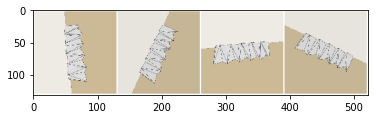

Output of network (To be verified with)


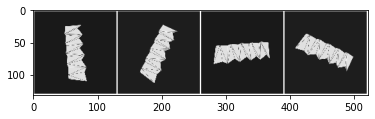

In [15]:
iterator = iter(train_loader)
sample = iterator.next()
augmented,original = sample['augmented'],sample['original']

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
images_show = 8
print('Input to network')
imshow(torchvision.utils.make_grid(augmented[:images_show,:], nrow=4, padding=2, pad_value=1))
print('Output of network (To be verified with)')
imshow(torchvision.utils.make_grid(original[:images_show,:], nrow=4, padding=2, pad_value=1))

In [18]:
def train(model, device, train_loader, optimizer, epoch,log_interval=10):
    model.train()
    for batch_idx, sample in enumerate(train_loader):
        data, target = sample['augmented'],sample['original']
        
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.binary_cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch,loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for c, sample in enumerate(test_loader):
            data, target = sample['augmented'],sample['original']
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.binary_cross_entropy(output,target) # sum up batch loss
    test_loss /= max(1,c)

    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))

model = AugmentedAutoencoder().to(device)

if os.path.exists('AE.pt'):
    model.load_state_dict(torch.load('AE.pt'))

optimizer = optim.Adadelta(model.parameters(), lr=15)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)


In [11]:
epochs = 2
save_model = True
saved_pth = 'AE.pt'

for epoch in tqdm(range(1, epochs + 1), unit='epochs'):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, train_loader)


if save_model:
    torch.save(model.state_dict(), saved_pth)

/home/rohit/projects/3D_reconstruction/cv/lib/python3.6/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Train Epoch: 1 	Loss: 0.499945

Test set: Average loss: 0.5000

Train Epoch: 2 	Loss: 0.500041

Test set: Average loss: 0.5008




In [11]:
def cross_validation(model, device, test_loader,viewer=True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        validator = iter(test_loader)
        sample = next(validator)
        
        sample = sample.to(device)
        output = model(sample)
        encodings = model.encoder_op(sample)
        

    if viewer:
        images_show = 8
        
        print('Reconstructed')
        op = output[:images_show,:].cpu()
        imshow(torchvision.utils.make_grid(op, nrow=4, padding=2, pad_value=1))
                
        print('Input to Netowrk')
        imshow(torchvision.utils.make_grid(sample[:images_show,:].cpu(), nrow=4, padding=2, pad_value=1))  
        
    return sample, output, encodings

# Check your training here
Just change the folder in variable `origami_test_dir`

In [19]:
origami_test_dir = "small_data/s_test/in"
val_batch_size = 12

use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}


trns = transforms.Compose([ResizeValidate((128,128)), NormalizeValidate(),ToTensorValidate() ])
origami_test = ValidationGenerate(root_dir=origami_test_dir, transform=trns)
val_loader = DataLoader(origami_test, batch_size=val_batch_size,
                            shuffle=True,**kwargs)

/home/rohit/projects/3D_reconstruction/cv/lib/python3.6/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Reconstructed


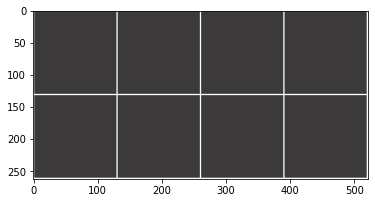

Input to Netowrk


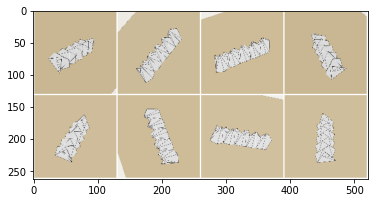

tensor([[-0.0008,  0.0032,  0.0276,  ...,  0.0087, -0.0114, -0.0055],
        [-0.0014,  0.0018,  0.0251,  ...,  0.0077, -0.0097, -0.0062],
        [-0.0017,  0.0023,  0.0253,  ...,  0.0095, -0.0127, -0.0051],
        ...,
        [-0.0011,  0.0010,  0.0283,  ...,  0.0073, -0.0112, -0.0051],
        [-0.0006,  0.0005,  0.0291,  ...,  0.0068, -0.0115, -0.0049],
        [-0.0028,  0.0015,  0.0289,  ...,  0.0078, -0.0097, -0.0081]],
       device='cuda:0')


In [20]:
sample, output, encodings = cross_validation(model, device, val_loader,viewer=True)